In this notebook, uncertainty of the final model is quantified via bootstrapping.

#### Notebook config

In [32]:
# %load ~/software/fullwavepy/fullwavepy/config/jupyter.py
from fullwavepy import * # Load modules imported in fullwavepy/__init__.py
# -----------------------------------------------------------------------------
# Set aliases of frequently used jupyter magic commands
# -----------------------------------------------------------------------------
%alias_magic mi matplotlib -p inline
%alias_magic mn matplotlib -p notebook
# -----------------------------------------------------------------------------
# Set matplotlib backend
# -----------------------------------------------------------------------------
# non-interactive plots displayed in a notebook cell
%matplotlib inline
# interactive plots displayed in a notebook cell
# %matplotlib notebook (interactive version)
# -----------------------------------------------------------------------------
# Set matplotlib style
# ----------------------------------------------------------------------------
plt.style.reload_library()
# a combined style (right overwrites left wherever they overlap):
plt.style.use(['default', 'ggplot'])
# print(plt.style.available) 
# -----------------------------------------------------------------------------
# Configure logging
# -----------------------------------------------------------------------------
# Set up loggers, handlers and load the log_lvl function
from fullwavepy.config.logging import *
# -----------------------------------------------------------------------------
# Set level of log-messages
log_lvl(ERROR) 
# Other options in order of increasing importance and 
# decreasing verbosity:
# TRACE, DEBUG, INFO, WARNING, ERROR, CRITICAL
# or using integers: 0, 10, 20, 30, 40, 50, respectively
# -----------------------------------------------------------------------------
# Autocompleting
# -----------------------------------------------------------------------------
#  Not sure if it works
#%config IPCompleter.greedy=True 
# -----------------------------------------------------------------------------
# Automatically reload modules before execution
#%load_ext autoreload
#%autoreload 2

Created `%mi` as an alias for `%matplotlib inline`.
Created `%mn` as an alias for `%matplotlib notebook`.


In [33]:
from fullwavepy.seismic.data import Dat, DataFileSgy #, DataSet

Set the path for projects accessible by the computational cluster:

In [34]:
path_eph = '/home/kmc3817/rds_home/my_ephemeral/PROJECTS/ch08_Kolumbo_volcano'
exe = {'fullwave': '~/PhD/fullwave3D/rev690/bin/fullwave3D.exe',
       'segyprep': '/home/kmc3817/light_PhD/fullwave3D/segyprep_v3.16/bin/segyprep_v3.16'}

Init the existing synthetic project. 

In [35]:
xp = PROTEUS()
box = xp.box['kol1']
box.box

[8000.0, 25000.0, -3000.0, 15000.0, 0, 4000.0]

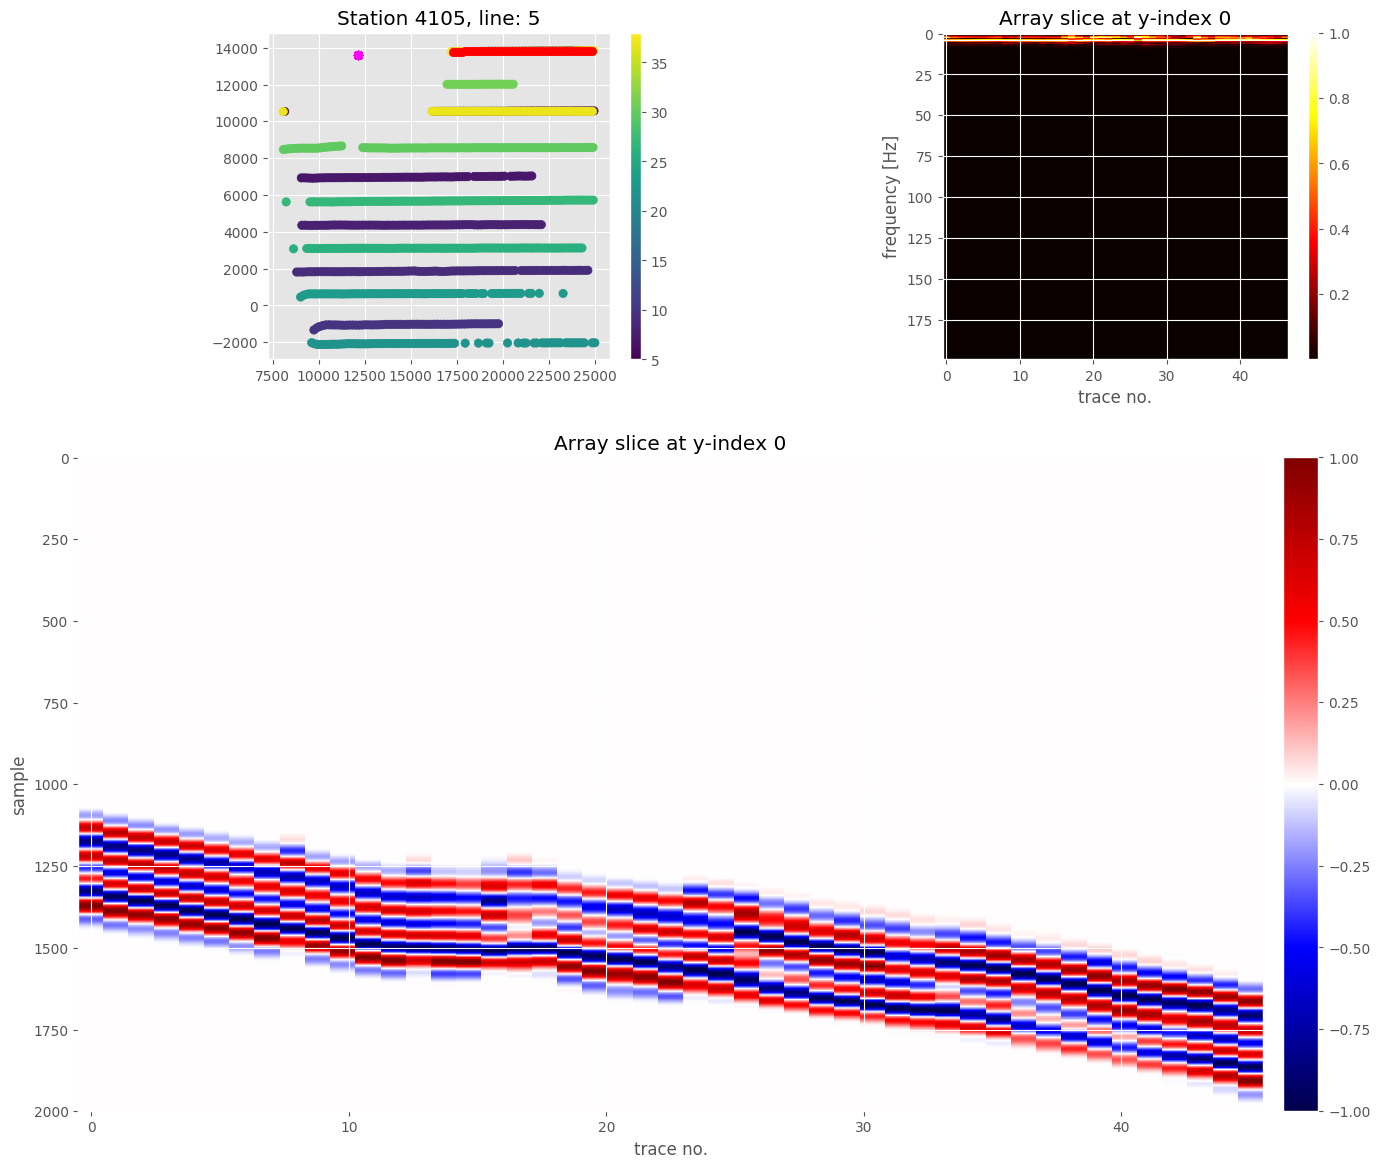

In [43]:
plot_data_and_geom(p.i.obs, p.i.obs.read_header(), 4105, 5)

# Get data
These are processed and hand-selected traces used in the final inversion.

In [87]:
path_p14 = '/home/kmc3817/c_projects_phd/fwi_sant_kolumbo/'
p14 = ProjInv('p14', path=path_p14, dt = 0.0025, ns = 2000, dx=50, box=box.box, cat=0)
# !cp {p14.i.obs.fname} 'data/'{p14.i.obs.name}

In [17]:
p14.i.obs.name

'p14-Observed.sgy'

In [36]:
name = 'p14-Observed.sgy'
path = './data/'
d14 = Dat(DataFileSgy(name, path), dt=0.0025)

#### Tab.
SEGY Header

In [35]:
d14.file.surange()

3200+0 records in
6+1 records out
3200 bytes (3.2 kB, 3.1 KiB) copied, 0.00433034 s, 739 kB/s

15632 traces:
tracl    3555 13370 (3559 - 13361)
tracr    5 19287 (5 - 19287)
fldr     17567 42821 (17571 - 42812)
tracf    4104 4178 (4104 - 4176)
ep       5 38 (5 - 38)
cdpt     0 1 (0 - 1)
offset   5000 20252 (9814 - 18652)
gelev    -410 456 (417 - -410)
selev    -12
sdepth   12
swdep    45 503 (398 - 398)
gwdep    196 456 (417 - 410)
scalel   1
scalco   1
sx       8051 24996 (8860 - 9610)
sy       -2126 13847 (13743 - 13732)
gx       8863 24030 (18674 - 21101)
gy       -1040 13806 (13806 - -960)
counit   1
tstat    250
delrt    0 5 (0 - 4)
muts     1883 4860 (3383 - 4773)
mute     2883 5860 (4383 - 5773)
ns       2000
dt       2500
gain     0 1 (1 - 0)
igc      0 16 (16 - 0)
year     2015
day      331 340 (331 - 340)
hour     0 23 (3 - 15)
minute   0 59 (10 - 7)
sec      0 59 (54 - 24)
timbas   0 1000 (120 - 782)
ntr      19296

Shot coordinate limits:
	North(23852,13847) South(10038,-212

# Define ensemble

Each project of the ensemble will lack one (unique) station compared to the `d14` dataset.

In [37]:
class ProjEnsemble:
    def __init__(self, name, path):
        self.name = name
        self.path = path
class BootstrapEnsemble(ProjEnsemble):
    def init(self, ids, *args, **kwargs):
        self.stations = {}
        self.proj = {}
        for exclude in ids:
            self.stations[exclude] = [i for i in ids if i != exclude]
            pname = '%s_%s' % (self.name, exclude)
            self.proj[exclude] = ProjInv(pname, *args, **kwargs)
en = BootstrapEnsemble(name='bstrap_p14', path='./')

# Projects

## Inp

Get all stations IDs:

In [38]:
ids = d14.file.read_header().tracf.unique()
ids

array([4104, 4109, 4112, 4124, 4125, 4137, 4157, 4158, 4177, 4178, 4105,
       4110, 4123, 4138, 4139, 4176])

In [39]:
path = './'
# path = path_eph
en.init(ids, path=path, exe=exe, dt=0.0025, ns=2000, dx=50, box=box.box, cat=0)

We need only 3 basic pieces of input: start vp, source wavelet and observed data

In [89]:
%%time 
# took 4.5 min for 15 projects (no 4104)
for key, p in en.proj.items():
    if key == 4104:
        continue
    p = en.proj[key]
    stations = en.stations[key]
    p.i.svp.dupl(p14.i.svp.fname)
    p.i.rsg.dupl(p14.i.rsg.fname)
    p.i.rse.prep(fnames=[p.i.obs.raw.name])
    p.i.sp.prep(reciprocity=True, ztype='d', outseis=False, outsource=False)
    # prepare data
    d14.file.window(win=dict(tracf=stations), nfname=p.i.obs.raw.fname)
    # Pre-process the input with `SP`
    p.i.sp.run()
    p.i.rnf.prep(b_abs=40, e_abs=50)

## Run

### Submit

#### `4104`

In [81]:
p = en.proj[4104]
p.reinit(path='./')
# p.i.pbs.no[0].prep(q='debug')
# p.i.pbs.no[1].prep(hours=1, select=4, mpiprocs=4, q='pqmrwarn') # only 4 completed iterations
# p.i.pbs.no[2].prep(hours=1, select=6, mpiprocs=8, q='pqmrwarn') # failed (cx1 error?)
# p.i.pbs.no[3].prep(hours=1, select=6, mpiprocs=8, q='pqmrwarn') # only 2 completed iterations!
# p.i.pbs.no[4].prep(hours=1, select=8, mpiprocs=2, q='pqmrwarn') # deleted after all
p.i.pbs.no[5].prep(hours=12, select=4, mpiprocs=4, q='pqmrwarn')
p.i.rsync('my_eph')

Content of  .//bstrap_p14_4104//inp/bstrap_p14_4104-Run5.pbs : 
#!/bin/bash

##
# FULLWAVE3D WILL BE RUN FROM proj/out/
# For more explanation, see help(fullwavepy.project.files.runfiles.PbsFile).
#
##

#PBS -N bstrap_p14_4104
#PBS -o ../out/bstrap_p14_4104-JobOut5.log
#PBS -e ../out/bstrap_p14_4104-JobErr5.log
#PBS -l walltime=12:00:00
#PBS -l select=4:mpiprocs=4:ompthreads=10:ncpus=40:mem=128gb
#PBS -l place=scatter:excl

start=`date +%s`

    # PATHS
    code_path=~/PhD/fullwave3D/rev690/bin/fullwave3D.exe
    echo 'code_path: '${code_path}

    work_dir=$PBS_O_WORKDIR/../out/ # $PBS_O_WORKDIR IS THE ONE CONTAINING THIS SCRIPT
    
    # CAVEAT  
    rm $work_dir/bstrap_p14_4104-Runfile.key   
    rm $work_dir/bstrap_p14_4104-Ghost.*


    # HARD-LINK INPUT FILES TO OUTPUT DIR WHERE THE CODE WILL RUN
    ln $PBS_O_WORKDIR/* $work_dir
    
    # CHANGE DIRECTORY TO PROJECT OUTPUT
    cd $work_dir
    
    
# DISABLE PINNING OF THE PROCESSES (MAKE ALL NODE CORES AVAILABLE TO ALL PROCE

#### Others

In [92]:
%%time 
# took a long while 
for key, p in en.proj.items():
    if key == 4104:
        continue
#     p.reinit(path='./')
#     p.i.pbs.no[1].prep(hours=12, select=4, mpiprocs=4, q='pqmrwarn')
    p.i.rsync('my_eph')

In [109]:
fname = '/home/kmc3817/rds_home/%s.txt' % en.name
with open(fname, 'w') as f:
    for key, p in en.proj.items():
        if key == 4104:
            continue
        f.write('%s\n' %p.name)
!cat {fname}

bstrap_p14_4176
bstrap_p14_4105
bstrap_p14_4138
bstrap_p14_4139
bstrap_p14_4109
bstrap_p14_4110
bstrap_p14_4125
bstrap_p14_4112
bstrap_p14_4177
bstrap_p14_4178
bstrap_p14_4137
bstrap_p14_4123
bstrap_p14_4124
bstrap_p14_4157
bstrap_p14_4158


### List output

In [100]:
p.reinit(path=path_eph)
p.o.ls()

Content of /home/kmc3817/rds_home/my_ephemeral/PROJECTS/ch08_Kolumbo_volcano/bstrap_p14_4104/out

total 9.5G
-rwx------ 1 kmc3817 root  76K Nov  5 04:01 bstrap_p14_4104-Out5.log
-rwx------ 1 kmc3817 root  21M Nov  5 03:56 bstrap_p14_4104-SLAVES_DUMPCOMPARE-csref04137-iter00012fwd1.ttr
-rwx------ 1 kmc3817 root  21M Nov  5 03:56 bstrap_p14_4104-SLAVES_DUMPCOMPARE-csref04110-iter00012fwd1.ttr
-rwx------ 1 kmc3817 root  25M Nov  5 03:56 bstrap_p14_4104-SLAVES_DUMPCOMPARE-csref04158-iter00012fwd1.ttr
-rwx------ 1 kmc3817 root  25M Nov  5 03:56 bstrap_p14_4104-SLAVES_DUMPCOMPARE-csref04123-iter00012fwd1.ttr
-rwx------ 1 kmc3817 root  24M Nov  5 03:56 bstrap_p14_4104-SLAVES_DUMPCOMPARE-csref04177-iter00012fwd1.ttr
-rwx------ 1 kmc3817 root  22M Nov  5 03:56 bstrap_p14_4104-SLAVES_DUMPCOMPARE-csref04109-iter00012fwd1.ttr
-rwx------ 1 kmc3817 root  22M Nov  5 03:55 bstrap_p14_4104-SLAVES_DUMPCOMPARE-csref04125-iter00012fwd1.ttr
-rwx------ 1 kmc3817 root  22M Nov  5 03:55 bstrap_p14_4104-SLAVES

### Check logs

In [71]:
no = 3
p.o.o.no[no].cat()

Content of  /home/kmc3817/rds_home/my_ephemeral/PROJECTS/ch08_Kolumbo_volcano/bstrap_p14_4104//out/bstrap_p14_4104-Out3.log : 
# mpiexec: No RDMA network found -- using sockets+shared memory (I_MPI_DEVICE=ssm)
# mpiexec: full path to program is /rds/general/user/kmc3817/home/PhD/fullwave3D/rev690/bin/fullwave3D.exe
# mpiexec: program arguments are: bstrap_p14_4104 -1 5
# mpiexec: 48 ranks allocated via PBS select
# mpiexec: 5 OpenMP threads / rank allocated by PBS select
# mpiexec: Job has shared use of the allocated nodes. Disabling process-pinning
# mpiexec: machinefile configured as:
cx1-104-10-3.cx1.hpc.ic.ac.uk:8
cx1-104-10-4.cx1.hpc.ic.ac.uk:8
cx1-104-11-1.cx1.hpc.ic.ac.uk:8
cx1-104-14-3.cx1.hpc.ic.ac.uk:8
cx1-104-19-1.cx1.hpc.ic.ac.uk:8
cx1-104-5-2.cx1.hpc.ic.ac.uk:8
#
# mpiexec: Checking all nodes are ONLINE:
# mpiexec: All nodes appear ONLINE
# mpiexec: launch started at Fri  5 Nov 01:18:40 GMT 2021
# mpiexec: launching program...
# /rds/general/user/kmc3817/home/PhD/fullwave3

In [72]:
# no = 3
# p.o.o.no[no].cat()

## Out

### Objective function

#### `bstrap_p14_4104`

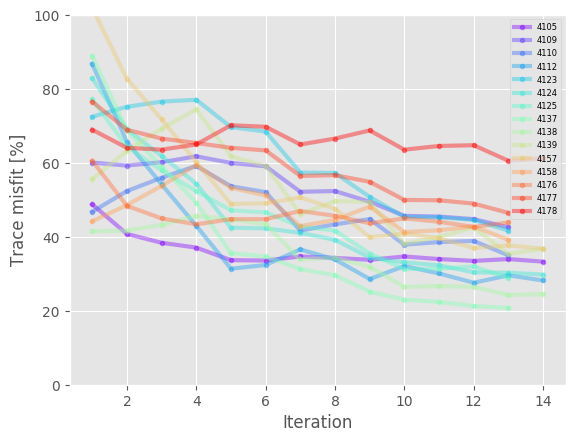

In [110]:
p = en.proj[4104]
p.reinit(path_eph)
p.o.fit.plot(run_ids=[1,3,5])

### Data

#### `bstrap_p14_4104`

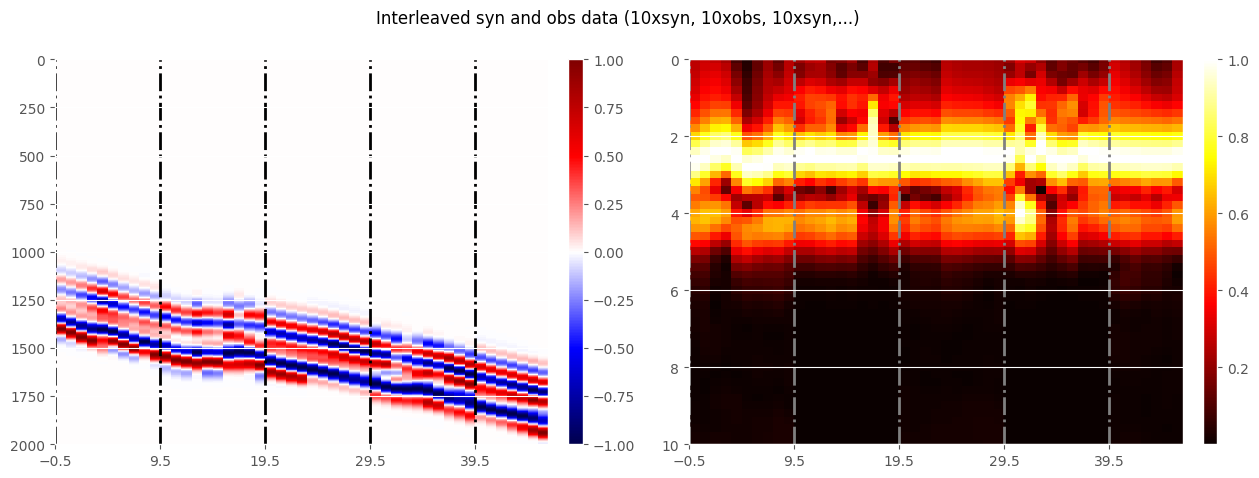

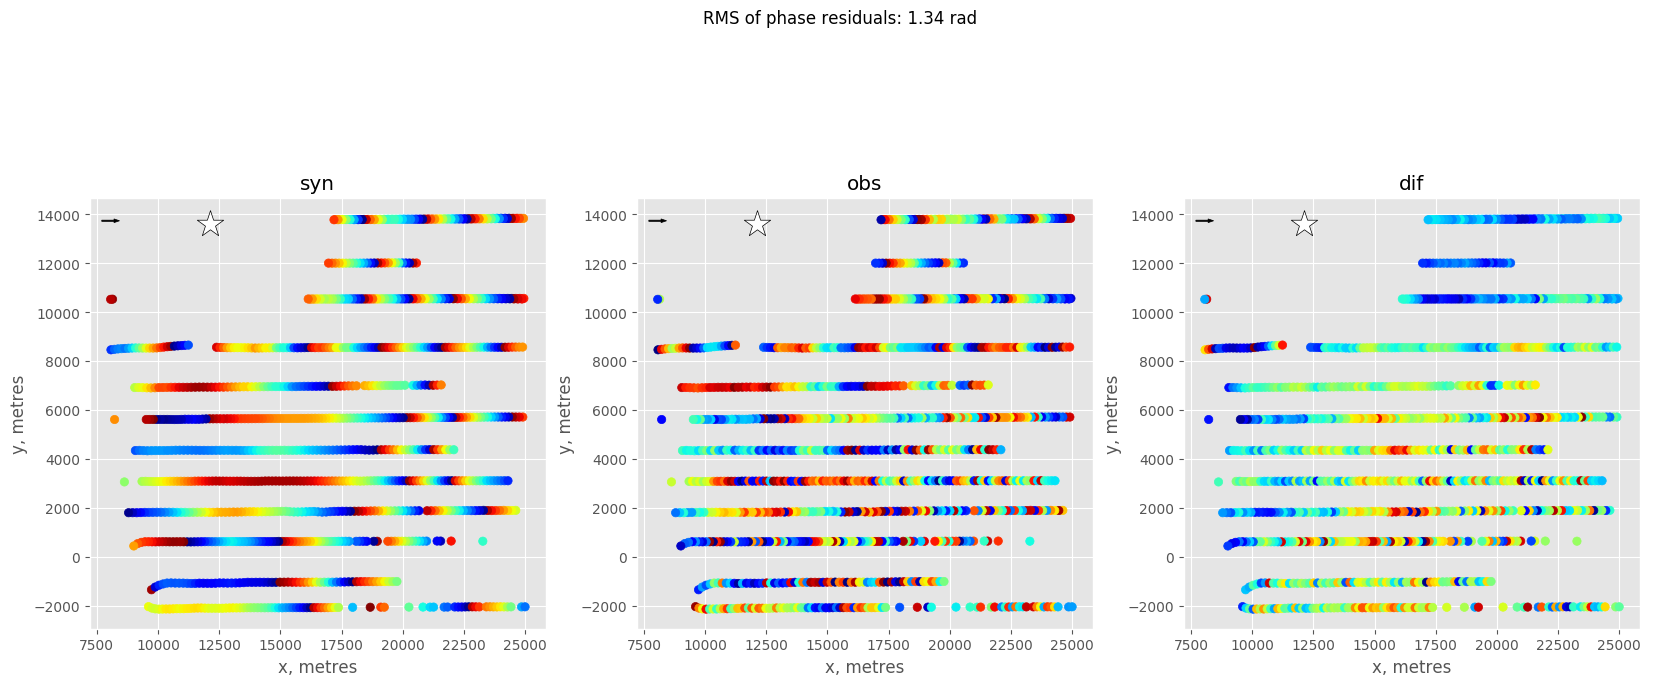

In [66]:
_ = plot_out_data(p, it=1, sid=4105, lid=5, freq=3, interleave=1, overwrite=0)

/home/kmc3817/software/fullwavepy/fullwavepy/project/files/datalike/ttr.py:215: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  (df['selev'] + df['gelev'])**2)


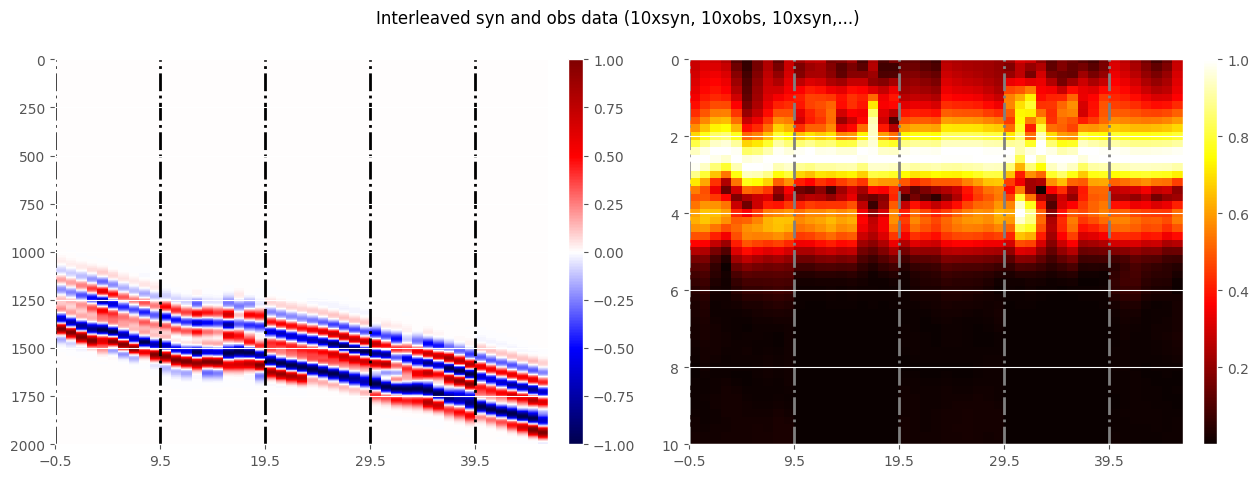

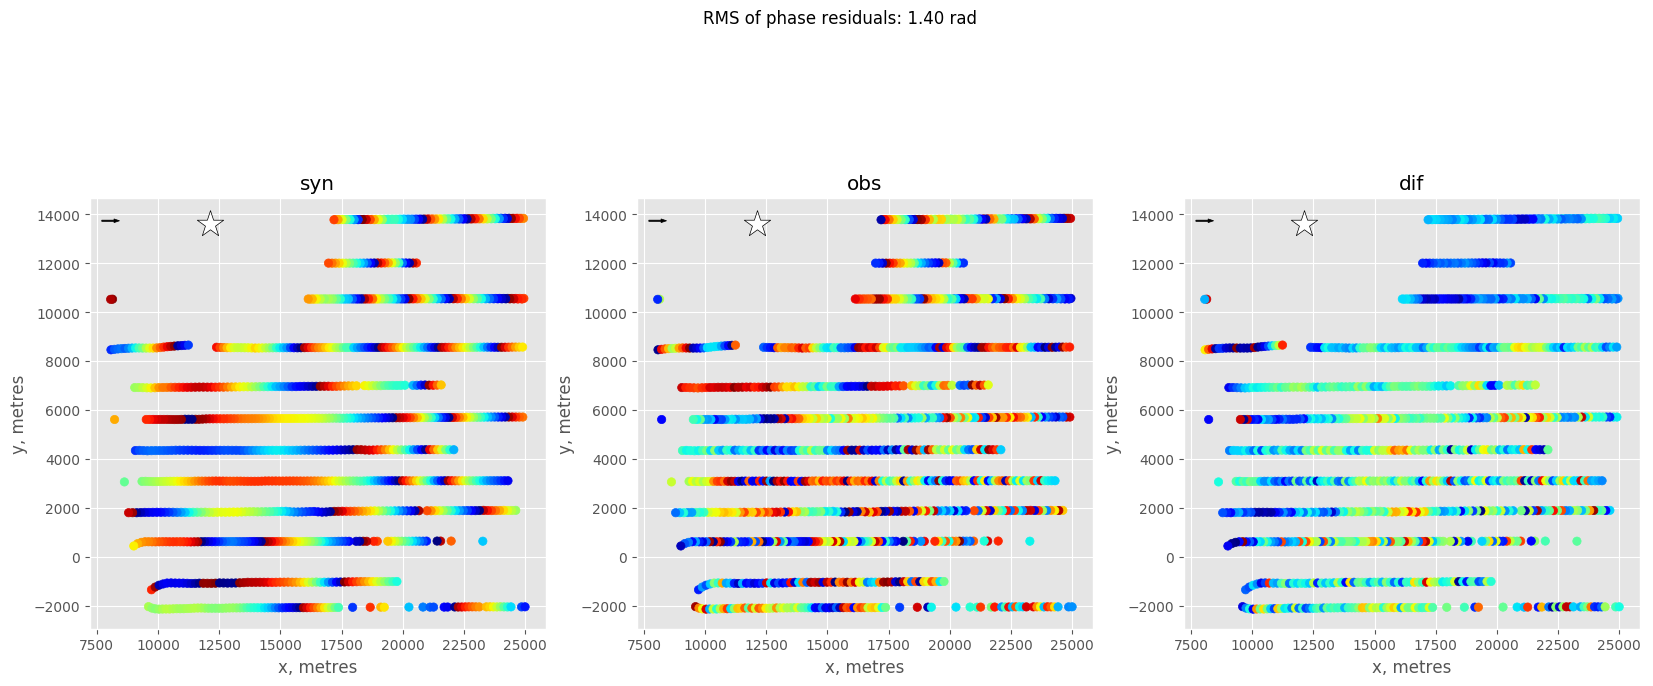

In [47]:
_ = plot_out_data(p, it=4, sid=4105, lid=5, freq=3, interleave=1, overwrite=0)

### Models

#### `bstrap_p14_4104`

In [97]:
p.reinit(path_eph)

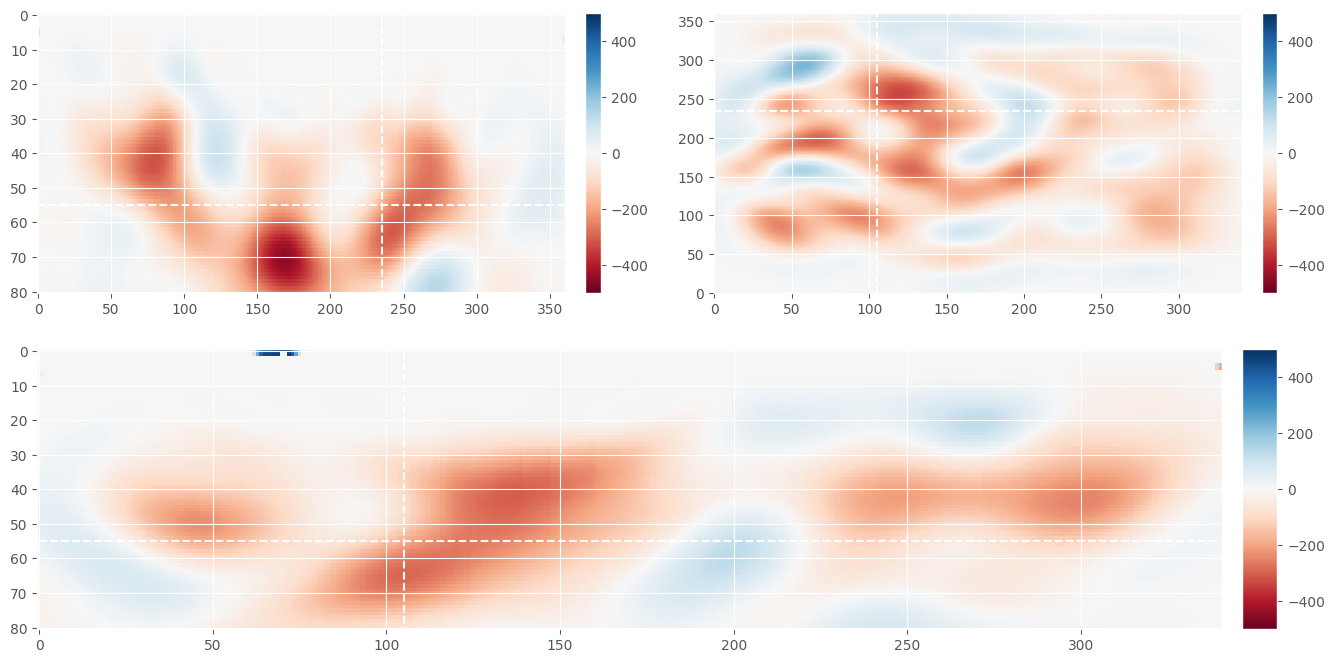

In [46]:
kws = dict(x=105, y=235, z=55)
a_minus_b(p.o.vp.it[4], p.i.svp, **kws)

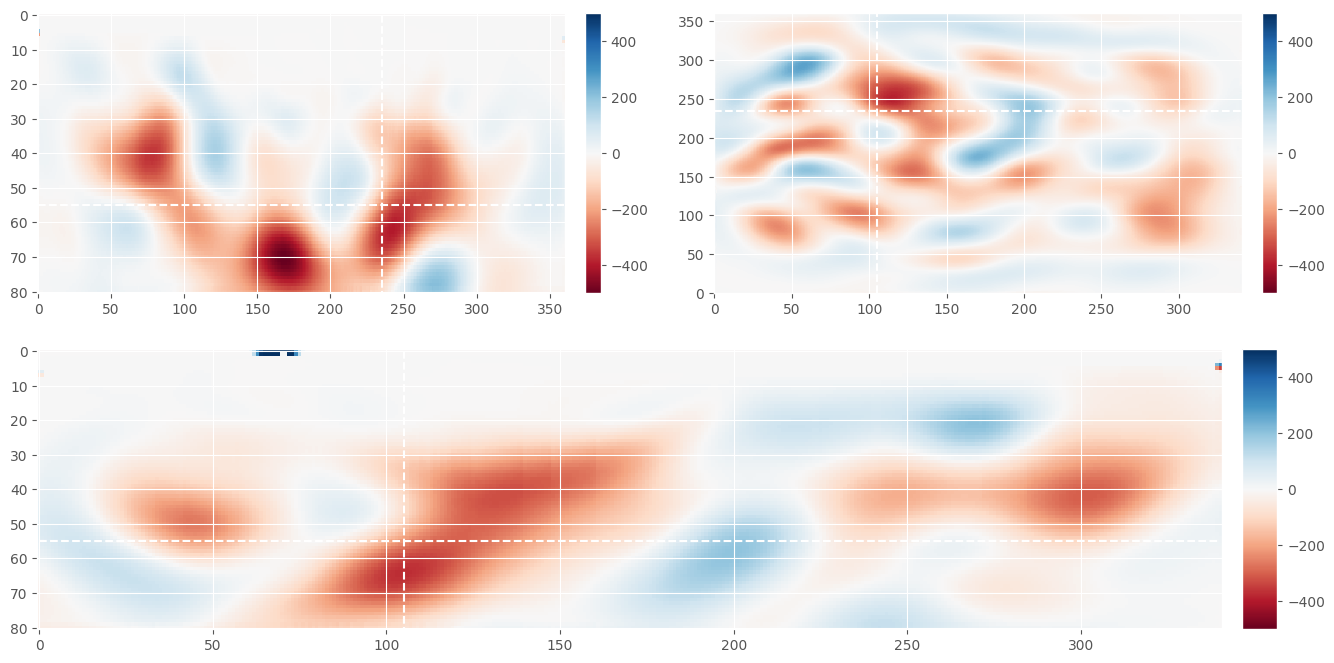

In [75]:
kws = dict(x=105, y=235, z=55)
a_minus_b(p.o.vp.it[6], p.i.svp, **kws)

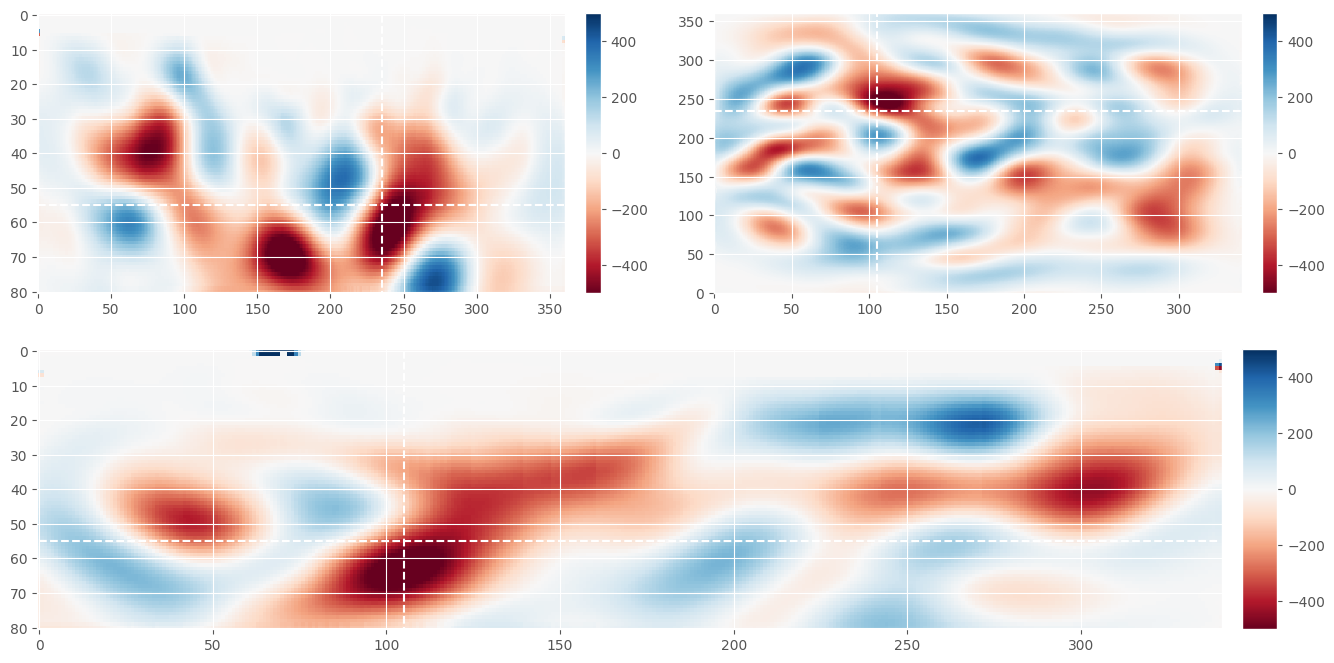

In [85]:
kws = dict(x=105, y=235, z=55)
a_minus_b(p.o.vp.it[9], p.i.svp, **kws)

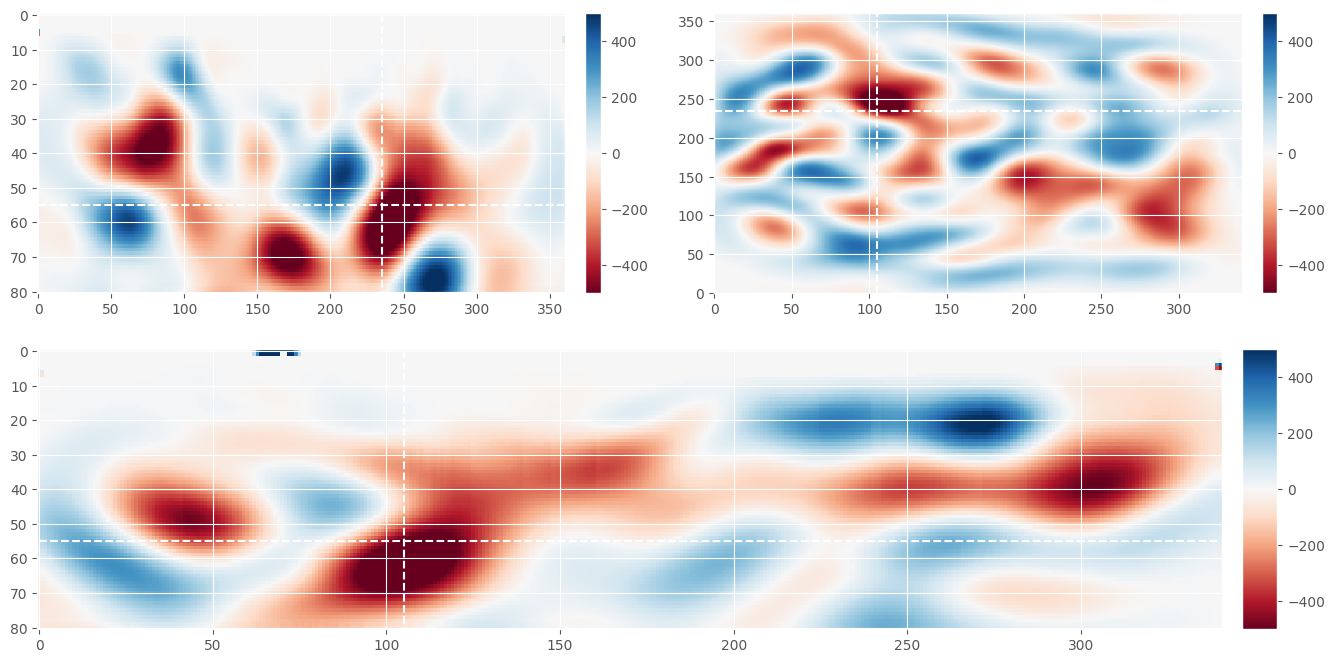

In [111]:
kws = dict(x=105, y=235, z=55)
a_minus_b(p.o.vp.it[12], p.i.svp, **kws)

# ...